In [ ]:
pip install memory_profiler

In [ ]:
import pandas as pd
import numpy as np
import cv2
import time
import psutil
from memory_profiler import memory_usage
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
# from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import psutil
# import resource
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc

In [ ]:
# Define the image size
import os
IMG_SIZE = 50

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/CSV


# train_df = pd.read_csv("./train_feature_index.csv")
# test_df = pd.read_csv("./test_feature_index.csv")
# train_df = pd.read_csv("./train_final_index.csv")
# test_df = pd.read_csv("./test_final_index.csv")
train_df = pd.read_csv("./train_final_index_2.csv")
test_df = pd.read_csv("./test_final_index_2.csv")

path = "/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/fiveTwelve"
print("found", os.path.exists(path=path))


Mounted at /content/drive
/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/CSV
found True


In [ ]:
import pandas as pd
X_train = train_df.drop(columns=["label", "path"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "path"])
y_test = test_df["label"]

# plotCorrelationMatrix(train_df, 8)
# plotScatterMatrix(train_df, 20, 10)

def load_and_preprocess_image(path):
    image = cv2.imread(path)
    if(image is not None):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0
      return image

In [ ]:
#Remove the memory code after testing
# Sample 1
process = psutil.Process()
before_memory = process.memory_info().rss / 1024 / 1024  # Convert to MB
print("process", process, "before Memory", before_memory)

process psutil.Process(pid=428, name='python3', status='running', started='21:16:42') before Memory 583.30078125


In [ ]:
def image_generator(X, y, batch_size=32):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        batch_indices = []
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices.extend(indices[start:end])

            if len(batch_indices) == batch_size:
                batch_X = np.zeros((batch_size, 224, 224, 3))
                batch_y = np.zeros((batch_size,))  # Use num_classes from your problem

                for i, idx in enumerate(batch_indices):
                    if idx >= num_samples:
                        continue  # Skip this sample

                    if "path" not in X.iloc[idx]:
                        continue  # Skip this sample if 'path' key is missing

                    path = X.iloc[idx]["path"]
                    image = load_and_preprocess_image(path)
                    if image is None:
                        continue  # Skip this sample

                    batch_X[i] = image
                    batch_y[i] = y.iloc[idx]

                yield batch_X, batch_y
                batch_indices = []

        # If there are remaining samples that don't form a full batch, process them as well
        if batch_indices:
            batch_X = np.zeros((len(batch_indices), 224, 224, 3))
            batch_y = np.zeros((len(batch_indices), 10))  # Use num_classes from your problem
            for i, idx in enumerate(batch_indices):
                if idx >= num_samples:
                    continue  # Skip this sample

                if "path" not in X.iloc[idx]:
                    continue  # Skip this sample if 'path' key is missing

                path = X.iloc[idx]["path"]
                image = load_and_preprocess_image(path)
                if image is None:
                    continue  # Skip this sample

                batch_X[i] = image
                batch_y[i] = y.iloc[idx]

            yield batch_X, batch_y


def load_and_preprocess_image(path):
    image = cv2.imread(path)
    if(image is not None):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0
    return image

X_train = train_df.drop(columns=["label", "path_id"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "path_id"])
y_test = test_df["label"]

In [ ]:
def run_code():
    base_model = EfficientNetB7(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    train_generator = image_generator(X_train, y_train, 250)
    test_generator = image_generator(X_test, y_test, 250)

    X_train_processed, y_train_processed = next(train_generator)
    X_test_processed, y_test_processed = next(test_generator)

    epochs = 5
    accuracy_history = []
    loss_history = []
    val_accuracy_history=[]
    val_loss_history=[]

    for epoch in range(epochs):
        history = model.fit(X_train_processed, y_train_processed, epochs=1, validation_data=(X_test_processed, y_test_processed))
        # Access training accuracy and loss for the current epoch
        training_accuracy = history.history['accuracy'][0]
        training_loss = history.history['loss'][0]

        # Access validation accuracy and loss for the current epoch
        validation_accuracy = history.history['val_accuracy'][0]
        validation_loss = history.history['val_loss'][0]

        # Append the accuracy and loss values for the current epoch to history
        accuracy_history.append(training_accuracy)
        loss_history.append(training_loss)
        val_accuracy_history.append(validation_accuracy)
        val_loss_history.append(validation_loss)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training loss: {training_loss:.4f}, Training accuracy: {training_accuracy:.4f}")
        print(f"Validation loss: {validation_loss:.4f}, Validation accuracy: {validation_accuracy:.4f}")

    print("accuracy_history:",accuracy_history)
    print("loss_history:",loss_history)
    print("val_accuracy_history:",val_accuracy_history)
    print("val_loss_history:", val_loss_history)
    # model.fit(X_train_processed, y_train_processed, validation_data=(X_test_processed, y_test_processed), epochs=10)

    print("Completed")
    test_loss, test_acc = model.evaluate(X_test_processed, y_test_processed)
    print("Test Loss:",test_loss, "Test accuracy:", test_acc)

    # Assuming y_test_processed contains binary labels (0 and 1)
    y_pred = model.predict(X_test_processed)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to binary labels

    # Generate classification report
    report = classification_report(y_test_processed, y_pred_labels)
    print(report)
    # Convert the data type of y_test_processed to integer
    y_test_processed = y_test_processed.astype(int)

    # Get predicted labels from the model
    y_pred = model.predict(X_test_processed)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_processed, y_pred_labels)

    # Print the confusion matrix
    # print("Confusion Matrix:")
    # print(cm)
    # print("confusion_matrix", cm)
    # Calculate the F1 score
    f1 = f1_score(y_test_processed, y_pred_labels, average='macro')
    print("F1 Score:", f1)

    # Plotting the accuracy and loss graphs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), accuracy_history, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), loss_history, label='Training Loss', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test_processed, y_pred[:, 1])
    # auc_pr = auc(recall, precision)
    # Calculate AUC
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve with AUC value
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve with AUC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    anomaly_threshold = 0.5  # Example anomaly detection threshold

    # Assuming you have obtained y_pred (predicted probabilities) from your model
    y_pred_labels = (y_pred[:, 1] > anomaly_threshold).astype(int)

    # Calculate the confusion matrix for anomaly detection
    cm_anomaly = confusion_matrix(y_test_processed, y_pred_labels)

    # Print the confusion matrix for anomaly detection
    print("Anomaly Detection Confusion Matrix:")
    print(cm_anomaly)
    return 1


8/8 [==============================] - 315s 39s/step - loss: 1.1883 - accuracy: 0.4920 - val_loss: 0.7166 - val_accuracy: 0.5720
Epoch 1/5
Training loss: 1.1883, Training accuracy: 0.4920
Validation loss: 0.7166, Validation accuracy: 0.5720
8/8 [==============================] - 283s 38s/step - loss: 0.7000 - accuracy: 0.5720 - val_loss: 0.6877 - val_accuracy: 0.5720
Epoch 2/5
Training loss: 0.7000, Training accuracy: 0.5720
Validation loss: 0.6877, Validation accuracy: 0.5720
8/8 [==============================] - 289s 39s/step - loss: 0.6888 - accuracy: 0.5560 - val_loss: 0.6875 - val_accuracy: 0.5720
Epoch 3/5
Training loss: 0.6888, Training accuracy: 0.5560
Validation loss: 0.6875, Validation accuracy: 0.5720
8/8 [==============================] - 259s 34s/step - loss: 0.7043 - accuracy: 0.5720 - val_loss: 0.6874 - val_accuracy: 0.5720
Epoch 4/5
Training loss: 0.7043, Training accuracy: 0.5720
Validation loss: 0.6874, Validation accuracy: 0.5720
8/8 [==============================]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       107
         1.0       0.57      1.00      0.73       143

    accuracy                           0.57       250
   macro avg       0.29      0.50      0.36       250
weighted avg       0.33      0.57      0.42       250

8/8 [==============================] - 125s 16s/step
F1 Score: 0.3638676844783715


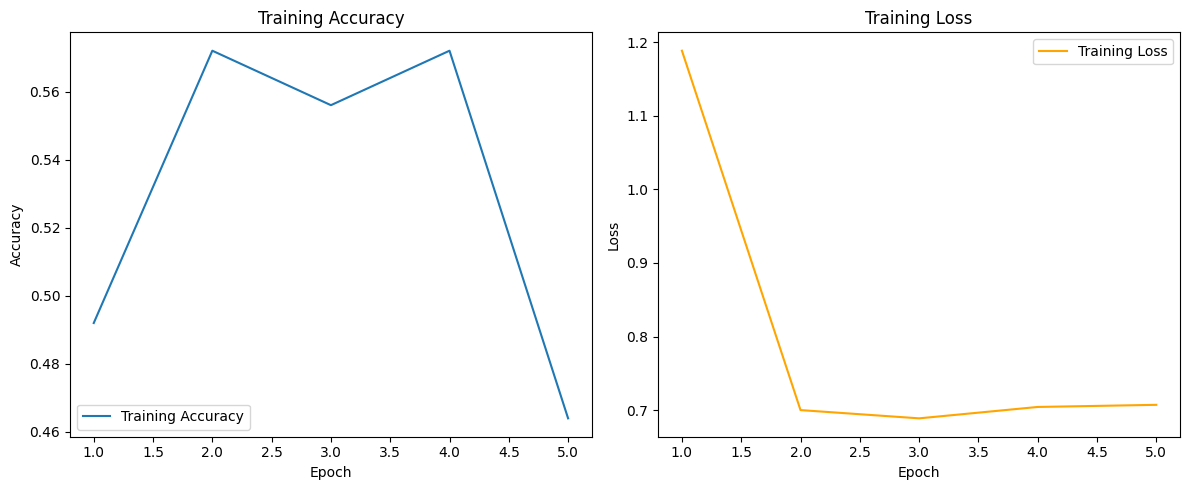

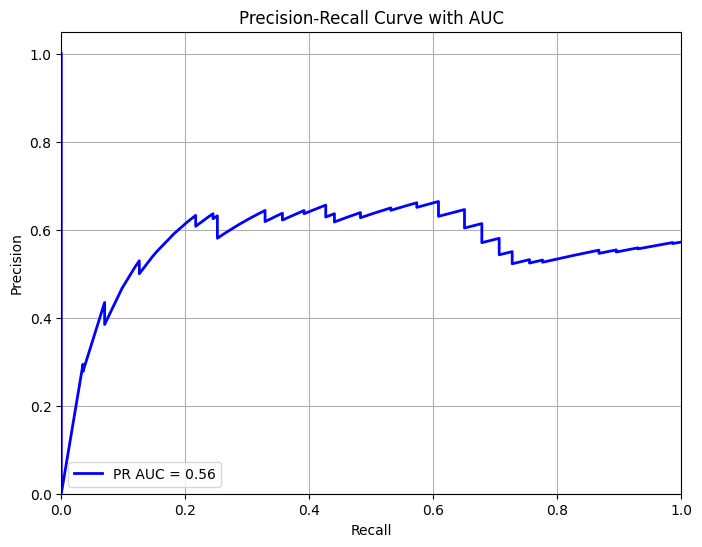

Anomaly Detection Confusion Matrix:
[[  0 107]
 [  0 143]]
Memory usage: 1929.26171875 MB


In [ ]:
# Method 1
run_code()
after_memory = process.memory_info().rss / 1024 / 1024  # Convert to MB
memory_usage = after_memory - before_memory

print("Memory usage:", memory_usage, "MB")

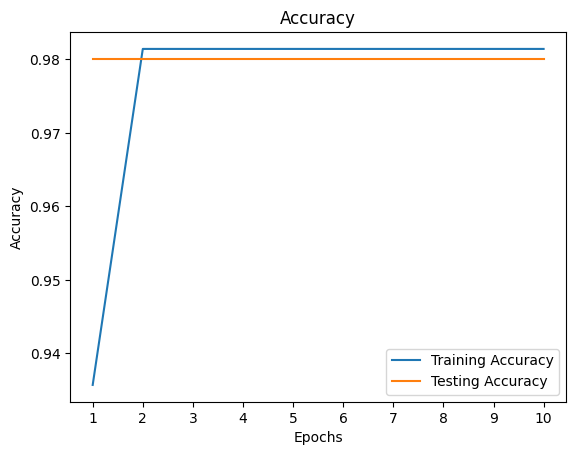

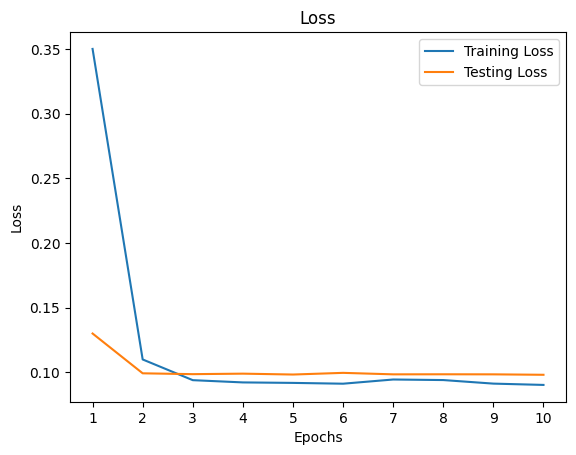

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs=10

# accuracy_history: [0.9257143139839172, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295]
# loss_history: [0.46958792209625244, 0.14741040766239166, 0.1383591890335083, 0.13793165981769562, 0.13710415363311768, 0.13649894297122955, 0.13754019141197205, 0.13685941696166992, 0.13607490062713623, 0.13791510462760925]
# val_accuracy_history: [0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863]
# val_loss_history:[0.12028566747903824, 0.10649502277374268, 0.09915704280138016, 0.09852055460214615, 0.10900817811489105, 0.09843689203262329, 0.10015417635440826, 0.0985293909907341, 0.10112480074167252, 0.09820926934480667]
# accuracy_history= [0.9357143044471741, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181]
# loss_history= [0.3500557243824005, 0.11005566269159317, 0.09405399113893509, 0.09231553971767426, 0.09194353222846985, 0.0913248136639595, 0.09456512331962585, 0.0941363275051117, 0.0913880318403244, 0.0903797298669815]
# val_accuracy_history= [0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863]
# val_loss_history= [0.13010980188846588, 0.14741040766239166, 0.1383591890335083, 0.13793165981769562, 0.13710415363311768, 0.13649894297122955, 0.13754019141197205, 0.13685941696166992, 0.13607490062713623, 0.13791510462760925, 0.09935364872217178, 0.09870020300149918, 0.09908819943666458, 0.09841014444828033, 0.09970080852508545, 0.09855392575263977, 0.09860457479953766, 0.09855222702026367, 0.09821378439664841]
accuracy_history_2= [0.9257143139839172, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9700000286102295, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181, 0.9814285635948181]
loss_history_2= [0.46958792209625244, 0.14741040766239166, 0.1383591890335083, 0.13793165981769562, 0.13710415363311768, 0.13649894297122955, 0.13754019141197205, 0.13685941696166992, 0.13607490062713623, 0.13791510462760925, 0.3500557243824005, 0.11005566269159317, 0.09405399113893509, 0.09231553971767426, 0.09194353222846985, 0.0913248136639595, 0.09456512331962585, 0.0941363275051117, 0.0913880318403244, 0.0903797298669815]
val_accuracy_history_2= [0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863]
val_loss_history_2= [0.1202856674790382, 0.10649502277374268, 0.09915704280138016, 0.09852055460214615, 0.10900817811489105, 0.09843689203262329, 0.10015417635440826, 0.0985293909907341, 0.10112480074167252, 0.09820926934480667, 0.09935364872217178, 0.09870020300149918, 0.09908819943666458, 0.09841014444828033, 0.09970080852508545, 0.09855392575263977, 0.09860457479953766, 0.09855222702026367, 0.09821378439664841]



# Plot exponential accuracy
plt.figure()
plt.plot(range(1, epochs + 1), accuracy_history, linestyle='-', label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy_history, linestyle='-', label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(False)
plt.xticks(np.arange(1, epochs + 1))
plt.legend()
plt.show()

# Plot exponential loss
plt.figure()
plt.plot(range(1, epochs + 1), loss_history, linestyle='-', label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_history, linestyle='-', label='Testing Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(False)
plt.xticks(np.arange(1, epochs + 1))
plt.legend()
plt.show()




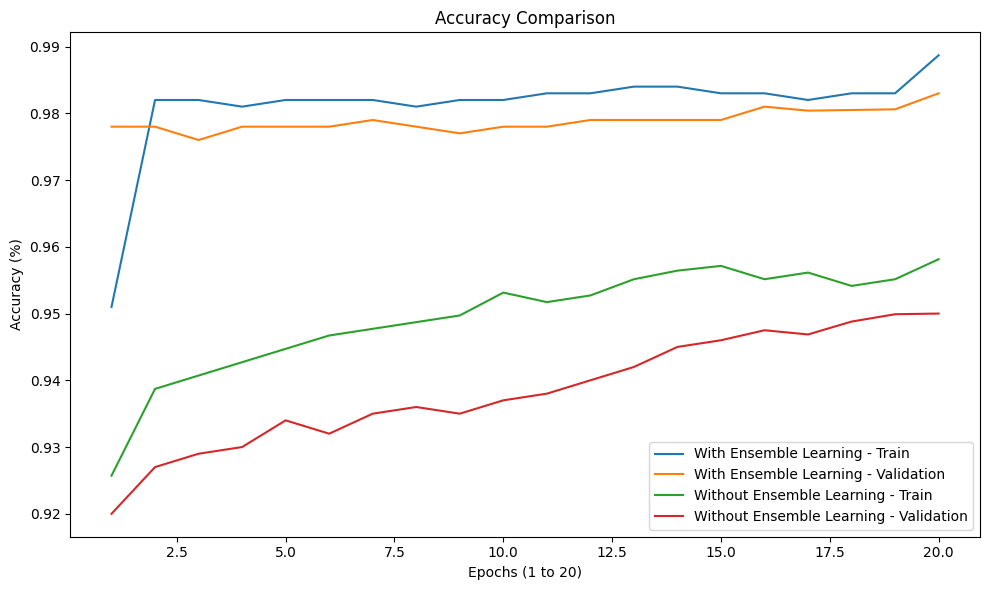

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# epochs=10
# Example accuracy lists for comparison

# Efficient
accuracy_history_1= [0.9509999752044678, 0.9819999933242798, 0.9819999933242798, 0.9810000061988831, 0.9819999933242798, 0.9819999933242798, 0.9819999933242798, 0.9810000061988831, 0.9819999933242798, 0.9819999933242798, 0.9829999804496765, 0.9829999804496765, 0.984000027179718, 0.984000027179718, 0.9829999804496765, 0.9829999804496765, 0.9819999933242798, 0.9830000238418579, 0.9829999804496765, 0.9886999804496765]
val_accuracy_history_1= [0.9779999852180481, 0.9779999852180481, 0.9760000109672546, 0.9779999852180481, 0.9779999852180481, 0.9779999852180481, 0.9789999723434448, 0.9779999852180481, 0.9769999980926514, 0.9779999852180481, 0.9779999852180481, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.980999981880188, 0.98039999852180481, 0.98049999723434448, 0.98059999723434448, 0.98299804496765]
loss_history_1= [0.3247755169868469, 0.10231038182973862, 0.11371006816625595, 0.15605399012565613, 0.12171082943677902, 0.11910519748926163, 0.0957203060388565, 0.086637943983078, 0.09041915088891983, 0.1100047156214714, 0.09041804820299149, 0.10733218491077423, 0.12004157155752182, 0.08535170555114746, 0.09000467509031296, 0.11985518038272858, 0.08735115826129913, 0.18272098898887634, 0.18951351940631866, 0.1017613336443901]
val_loss_history_1= [0.14181625843048096, 0.17144422233104706, 0.18897926807403564, 0.12031549215316772, 0.21855460107326508, 0.17237834632396698, 0.14472325146198273, 0.10136288404464722, 0.11747734248638153, 0.11302536725997925, 0.17010976374149323, 0.12460917979478836, 0.10156548023223877, 0.10003690421581268, 0.11541037261486053, 0.1382942795753479, 0.20902305841445923, 0.23911452293395996, 0.16047468781471252, 0.12961161136627197]
# ensemble
accuracy_history_2= [0.9257143139839172, 0.9387143139839172, 0.9407143139839172,0.9427143139839172, 0.9447143139839172, 0.9467143139839172, 0.9477143139839172, 0.9487143139839172,0.9497143139839172,0.953143139839172, 0.9517143139839172, 0.9527143139839172, 0.955143139839172, 0.95643139839172, 0.957143139839172, 0.955143139839172, 0.956143139839172, 0.954143139839172, 0.955143139839172, 0.958143139839172]
loss_history_2= [0.46958792209625244, 0.14741040766239166, 0.1383591890335083, 0.13793165981769562, 0.13710415363311768, 0.13649894297122955, 0.13754019141197205, 0.13685941696166992, 0.13607490062713623, 0.13791510462760925, 0.3500557243824005, 0.11005566269159317, 0.09405399113893509, 0.09231553971767426, 0.09194353222846985, 0.0913248136639595, 0.09456512331962585, 0.0941363275051117, 0.0913880318403244, 0.0903797298669815]
val_accuracy_history_2= [0.9200000190734863, 0.9270000190734863, 0.9290000190734863, 0.930000190734863, 0.934000190734863, 0.9320000190734863, 0.93500000190734863, 0.93600000190734863, 0.9350000190734863, 0.9370000190734863, 0.9380000190734863, 0.940000190734863, 0.9420000190734863, 0.9450000190734863, 0.9460000190734863, 0.947500190734863, 0.946870000190734863, 0.94880000190734863, 0.94990000190734863, 0.9500000190734863]
val_loss_history_2= [0.1202856674790382, 0.10649502277374268, 0.09915704280138016, 0.09852055460214615, 0.10900817811489105, 0.09843689203262329, 0.10015417635440826, 0.0985293909907341, 0.10112480074167252, 0.09820926934480667, 0.09935364872217178, 0.09870020300149918, 0.09908819943666458, 0.09841014444828033, 0.09970080852508545, 0.09855392575263977, 0.09860457479953766, 0.09855222702026367, 0.09821378439664841,  0.09821378439664841]

min_epoch = 1
max_epoch = 20
# print(len(accuracy_history_1))
# print(len(accuracy_history_2))
# Make sure all lists have the same length
min_length = min(len(accuracy_history_1), len(val_accuracy_history_1), len(accuracy_history_2), len(val_accuracy_history_2))
accuracy_history_1 = accuracy_history_1[min_epoch - 1:max_epoch]  # Extract values for epochs 11 to 20
val_accuracy_history_1 = val_accuracy_history_1[min_epoch - 1:max_epoch]
accuracy_history_2 = accuracy_history_2[min_epoch - 1:max_epoch]
val_accuracy_history_2 = val_accuracy_history_2[min_epoch - 1:max_epoch]

# Create a line plot
plt.figure(figsize=(10, 6))
# plt.subplot(2,2,2)
plt.plot(range(min_epoch, max_epoch + 1), accuracy_history_1, label='With Ensemble Learning - Train')
plt.plot(range(min_epoch, max_epoch + 1), val_accuracy_history_1, label='With Ensemble Learning - Validation')
plt.plot(range(min_epoch, max_epoch + 1), accuracy_history_2, label='Without Ensemble Learning - Train')
plt.plot(range(min_epoch, max_epoch + 1), val_accuracy_history_2, label='Without Ensemble Learning - Validation')

# Add labels and title
plt.xlabel('Epochs ({} to {})'.format(min_epoch, max_epoch))
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
